#### Step 1. Data Preprocessing & Cleaning
✔ Load the dataset\
✔ Identify and handle missing values (true missing vs. "NA" meaning absence)\
✔ Convert incorrect data types (e.g., numeric features stored as objects)\
✔ Handle outliers and anomalies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

In [1]:

train = pd.read_csv("home-data-for-ml-course\\train.csv")
test = pd.read_csv("home-data-for-ml-course\\test.csv")
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

NameError: name 'pd' is not defined

##### we got the categories from the description of the dataset info offered to us.

In [ ]:
#save the id
train_ID = train["Id"]
test_ID = test["Id"]

#drop ID duuuh..
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

train[["LotFrontage", "MasVnrArea", "GarageYrBlt"]] = train[["LotFrontage", "MasVnrArea", "GarageYrBlt"]].apply(pd.to_numeric, errors="coerce")

#group features for preprocessing purpose.
train_categorical = [feature for feature in train.columns if train[feature].dtype == "object"] 

train_nominal = ["MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", 
                    "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating",
                    "CentralAir", 'Electrical',"GarageType", "MiscFeature", "SaleType", "SaleCondition"]

train_ordinal = [ 'LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                    'BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
                    'GarageCond','PavedDrive','PoolQC','Fence']

train_numerical = [feature for feature in train.columns if feature not in train_categorical + ['SalePrice']]

discrete_numerical_train = [ 'OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath',
  'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','MoSold', "MSSubClass"] 

continuous_numerical_train = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
                                  'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageYrBlt',
                                  'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
                                  'MiscVal','YrSold']

In [ ]:
train.shape

(1460, 80)

#### Step 2.Exploratory Data Analysis (EDA)
✔ Visualize target variable (SalePrice)\
Identify correlations between features and SalePrice\
Analyze categorical vs. numerical features\
Detect and handle outliers\

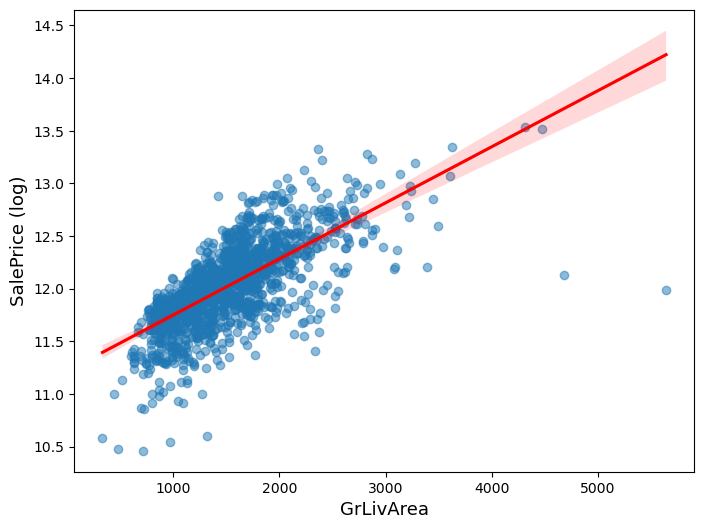

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(8,6))

# Scatter plot with regression line
sns.regplot(x=train['GrLivArea'], 
            y=np.log(train['SalePrice']), 
            ax=ax, 
            scatter_kws={'alpha': 0.5},  # Adjust transparency of points
            line_kws={'color': 'red'})  # Set line color

# Labels
ax.set_xlabel("GrLivArea", fontsize=13)
ax.set_ylabel("SalePrice (log)", fontsize=13)

# Show the plot
plt.show()

#box plot, check it its used for geting outliers.

#### after applying box plot i noticed there is numerical values stored as object64
***GarageYrBlt LotFrontage MasVnrArea***

In [ ]:
# ill use this code above
#train[["LotFrontage", "MasVnrArea", "GarageYrBlt"]] = train[["LotFrontage", "MasVnrArea", "GarageYrBlt"]].apply(pd.to_numeric, errors="coerce")

##### the freatures that we noticed have a strong correlation to the target value :
**1stFlrSF: First Floor square feet**\
**2ndFlrSF: Second floor square feet**\
**TotalBsmtSF : Total basement surface**


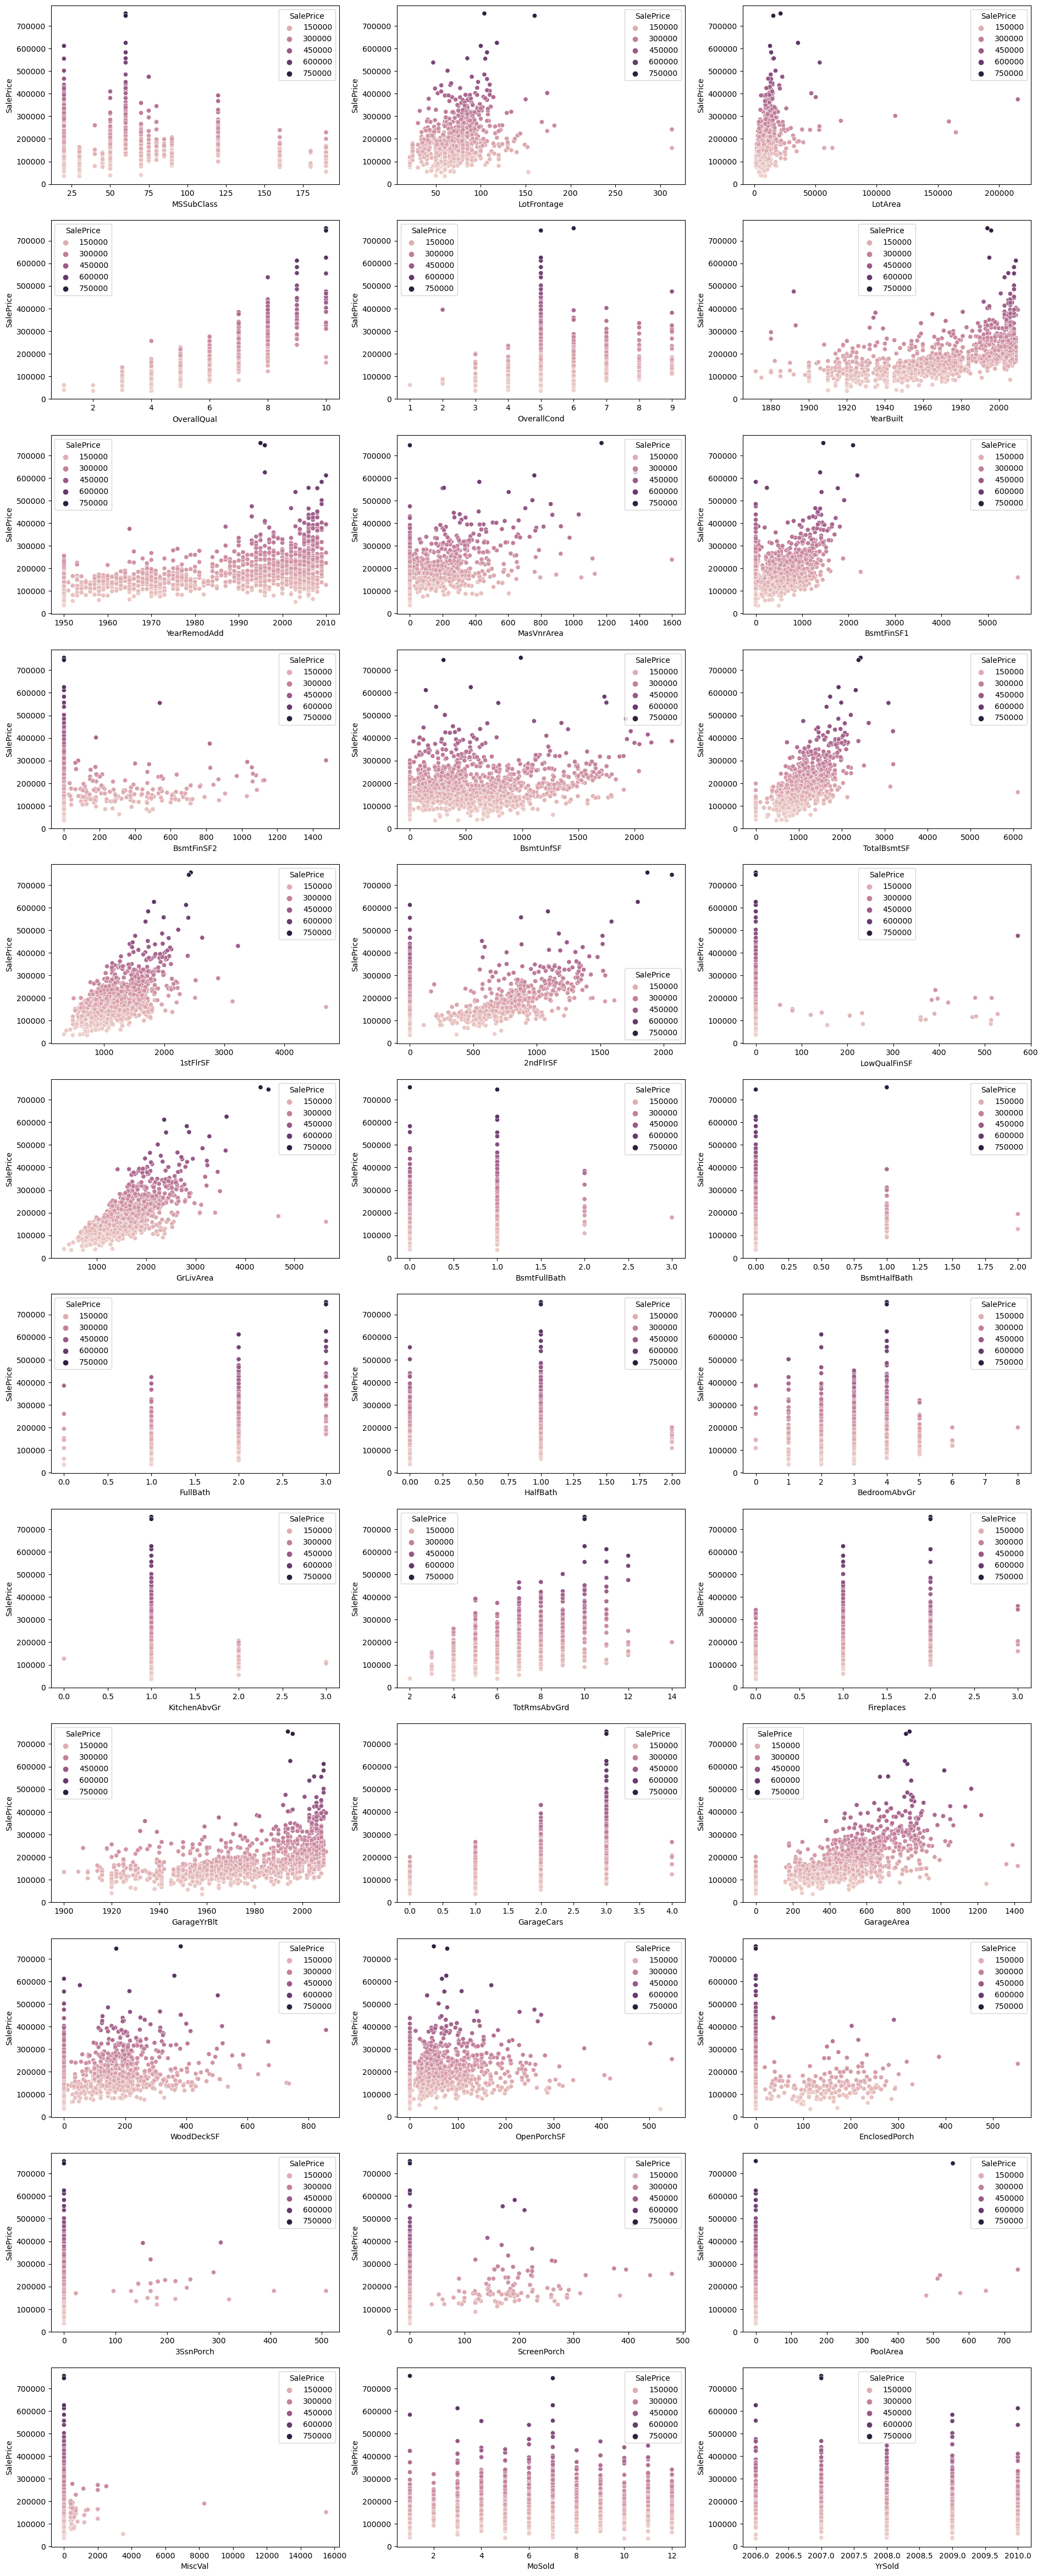

In [ ]:
fig, ax = plt.subplots(12, 3, figsize=(23, 60))
for var, subplot in zip(train_numerical, ax.flatten()):
    sns.scatterplot(x=var, y='SalePrice',  data=train, ax=subplot, hue = 'SalePrice' )

dropped visually appearing outliers

In [ ]:
train = train.drop(train[(train['BsmtFinSF1']>4000) & (train['SalePrice']<250000)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<250000)].index)

***Visualized the correlation between our target values [SalePrice] and all of our Features.***
- helps us understand our data better.
- show which features contributes more to the target value.
- show which features have the smallest effect incase we want to drop them.

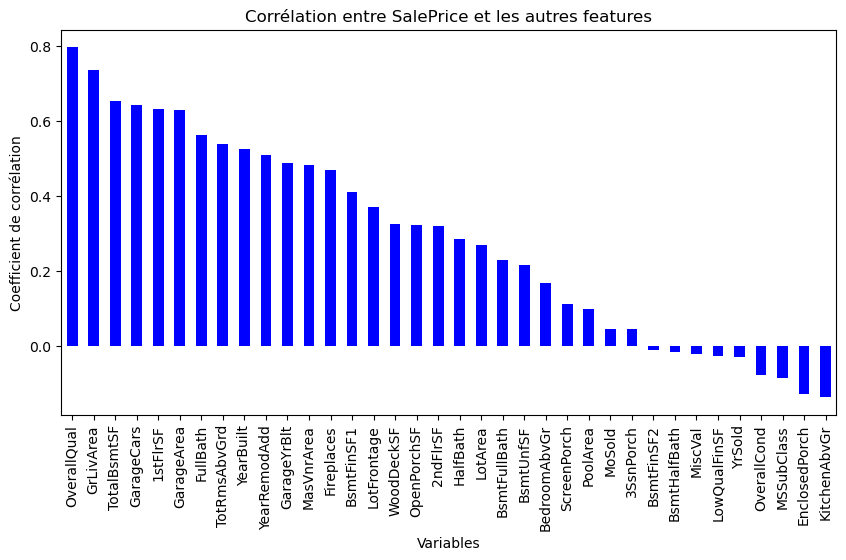

In [ ]:
#train_numerical.corr()
train_numerical = train[[feature for feature in train.columns if feature not in train_categorical]]

corr = train_numerical.corr()['SalePrice'].sort_values(ascending=False)
plt.figure(figsize=(10,5))
corr[1:].plot(kind='bar', color='b')  # Exclut SalePrice (qui a une corrélation de 1 avec lui-même)
plt.title("Corrélation entre SalePrice et les autres features")
plt.ylabel("Coefficient de corrélation")
plt.xlabel("Variables")
plt.show()

##### Calculating **Correlation** and **Mutuel Information**
- using correlation matrix to detect redundency in features.
- drop, or merge the features with high correlation.
- When two features have high correlation, they carry similar information. This can lead to:
- ***Redundant features*** → Makes the model more complex without adding value.
- ***Multicollinearity*** → Some models (like Linear Regression) perform poorly when features are strongly correlated.

##### What to do?
- If two features are highly correlated (above 0.8-0.9), we usually remove one.
- If they have a meaningful relationship, we can combine them into a new feature (e.g., **"TotalSF"** = **"1stFlrSF"** + **"2ndFlrSF"** + **"TotalBsmtSF"**).\
***correlation measure only linear relationships between features***

so we will calculate ***Mutuel Information*** aswell to describe the relationship between our features
- ***MI*** measures how much information one feature provides about another
- If ***MI*** is high, the feature is useful for predicting the target (SalePrice).
- If ***MI*** is low, the feature doesn’t contribute much information.

##### Highly correlated features *corr(x,y) > 0,8*
totalBsmtSf -- 1stFlrSf    ***0.80***\
yearBuilt -- GarageYrBlt   ***0.83***\
GrLiveArea -- totRmsAbvGrd ***0.83***\
GrLiveArea -- SalePrice    ***0.73***\
GarageCars -- GarageArea   ***0.89***

In [ ]:
corr_matrix = train_numerical.corr()
# sns.heatmap(corr_matrix, 
#             xticklabels=train_numerical.columns.values,
#             yticklabels=train_numerical.columns.values)
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_matrix[mask] = np.nan
(corr_matrix
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
LotFrontage,-0.41,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
LotArea,-0.14,0.39,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
OverallQual,0.03,0.24,0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
OverallCond,-0.06,-0.06,-0.00,-0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
YearBuilt,0.03,0.12,0.01,0.57,-0.38,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
YearRemodAdd,0.04,0.08,0.01,0.55,0.07,0.59,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
MasVnrArea,0.02,0.16,0.08,0.40,-0.13,0.31,0.18,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
BsmtFinSF1,-0.07,0.15,0.18,0.22,-0.04,0.25,0.12,0.24,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
BsmtFinSF2,-0.07,0.06,0.11,-0.06,0.04,-0.05,-0.07,-0.07,-0.05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


#### Numerical Features **MI**
 **No MI Features** : *3SsnPorch MoSol* \
 **Very Low MI Features** : *MiscVal PoolArea* \
 **Very High MI Features** : *OverallQual GrLivArea TotalBsmtSF	GarageCars  GarageArea	YearBuilt  1stFlrSF	 MSSubClass	FullBath GarageYrBlt*

In [ ]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
y = train.SalePrice
train_numerical = train.select_dtypes(include=["int64", "float64"]).columns.drop("SalePrice", errors="ignore")
mutual_df = train[train_numerical]


mutual_infoN = mutual_info_regression(mutual_df.fillna(0), y, random_state=1)

mutual_infoN = pd.Series(mutual_infoN)
mutual_infoN.index = mutual_df.columns
# pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] ).style.background_gradient("cool")
pd.DataFrame(mutual_infoN.sort_values(ascending=False), columns=["Mutual Information"]).style.background_gradient("coolwarm", axis=0)

,Mutual Information
OverallQual,0.574817
GrLivArea,0.484534
TotalBsmtSF,0.370944
GarageCars,0.367556
GarageArea,0.366143
YearBuilt,0.363164
1stFlrSF,0.314310
MSSubClass,0.279657
FullBath,0.262958
GarageYrBlt,0.256851


#### Categorical Features **MI**
 **No MI Features** : *RoofMatl Utilities Street PoolQC* \
 **Very Low MI** : *Functional LandSlope	Condition2	MiscFeature* \
 **Very High MI Features** : *Neighborhood ExterQual BsmtQual KitchenQual GarageFinish*

In [ ]:
mutual_df_categorical = train[train_categorical]
#categorical features must be encoded to get mutual information
for colname in mutual_df_categorical:
    mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()
mutual_infoC = mutual_info_regression(mutual_df_categorical.fillna("Do_not_have_feature"), y, random_state=1)

mutual_infoC = pd.Series(mutual_infoC)
mutual_infoC.index = mutual_df_categorical.columns
pd.DataFrame(mutual_infoC.sort_values(ascending=False), columns = ["Categorical_Feature_MI"] ).style.background_gradient("cool")

C:\Users\dhiaa\AppData\Local\Temp\ipykernel_20840\1440163093.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()
C:\Users\dhiaa\AppData\Local\Temp\ipykernel_20840\1440163093.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()
C:\Users\dhiaa\AppData\Local\Temp\ipykernel_20840\1440163093.py:4: SettingWithCopyWarning: 
A value is trying to be set on a cop

,Categorical_Feature_MI
ExterQual,0.328247
BsmtQual,0.325126
KitchenQual,0.321459
GarageFinish,0.264427
Foundation,0.198453
HeatingQC,0.169380
Neighborhood,0.135317
MSZoning,0.124089
MasVnrType,0.103644
FireplaceQu,0.094299


##### use ***.describe*** to help me set a threshold for my data

In [ ]:
mutual_infoN.describe()

count    36.000000
mean      0.164009
std       0.151454
min       0.000000
25%       0.020200
50%       0.135740
75%       0.258378
max       0.574817
dtype: float64

In [ ]:
mutual_infoC.describe()

count    43.000000
mean      0.075893
std       0.088652
min       0.000000
25%       0.019548
50%       0.044078
75%       0.081233
max       0.328247
dtype: float64

##### each dataset has a unique threshold that helps with figuring which features contribute more to our target value
 *i could use the general drop the Features with a MI value <0.01*
 *otherwise i could drop the ones less then %25 quertile*

In [ ]:
# 🔹 Define threshold using 10th percentile
mi_thresholdN = mutual_infoN.quantile(0.1)  # Drop bottom 10% MI features

# 🔹 Identify low MI features
low_mi_features = mutual_infoN[mutual_infoN < mi_thresholdN].index.tolist()

# 🔹 Drop them from the dataset
train.drop(columns=low_mi_features, inplace=True)

print(f"Dropped {len(low_mi_features)} numerical features with MI < {mi_thresholdN:.4f}")
print(f"Remaining features: {train.shape[1]}")

Dropped 4 numerical features with MI < 0.0064
Remaining features: 76


In [ ]:
# 🔹 Define threshold using 10th percentile
mi_thresholdC = mutual_infoC.quantile(0.1)  # Drop bottom 10% MI features

# 🔹 Identify low MI features
low_mi_features = mutual_infoC[mutual_infoC < mi_thresholdC].index.tolist()

# 🔹 Drop them from the dataset
train.drop(columns=low_mi_features, inplace=True)

print(f"Dropped {len(low_mi_features)} numerical features with MI < {mi_thresholdC:.4f}")
print(f"Remaining features: {train.shape[1]}")

Dropped 5 numerical features with MI < 0.0048
Remaining features: 71


In [ ]:
train.shape

(1458, 71)

In [ ]:
features_to_drop = ["GarageArea", "TotRmsAbvGrd", "1stFlrSF", "GarageYrBlt"]
train.drop(columns=features_to_drop, inplace=True)

print(f"Dropped {len(features_to_drop)} highly correlated features: {features_to_drop}")
train.shape

Dropped 4 highly correlated features: ['GarageArea', 'TotRmsAbvGrd', '1stFlrSF', 'GarageYrBlt']


(1458, 67)

In [ ]:
train_categorical = [feature for feature in train.columns if
                    train[feature].dtype == "object"]

train_ordinal = [ 'LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                    'BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
                    'GarageCond','PavedDrive','Fence']

train_nominal = list(set(train_categorical) - set(train_ordinal)) 
train_numerical = list(set(train.columns) - set(train_categorical)) 

In [ ]:
# Check for missing values
missing_values = train.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filter only missing columns
print(missing_values)


LotFrontage    259
MasVnrArea       8
dtype: int64


#### *Preproccessing*

In [ ]:
# Fill missing values with "NA" before applying encoding
train.fillna("NA", inplace=True)


In [ ]:
# # Strip spaces from all ordinal columns
# for col in ordinal_mapping.keys():
#     if col in train.columns:
#         train[col] = train[col].astype(str).str.strip()

In [ ]:
# # Define ordinal encoding mapping correctly
ordinal_mapping = {
    "GarageQual": {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    "Fence": {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0},
    "GarageFinish": {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0},
    "KitchenQual": {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    "GarageCond": {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    "HeatingQC": {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    "ExterQual": {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    "BsmtCond": {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    "ExterCond": {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    "BsmtExposure": {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0},
    "PavedDrive": {'Y': 2, 'P': 1, 'N': 0},
    "BsmtQual": {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    "LotShape": {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0},
    "BsmtFinType2": {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0},
    "BsmtFinType1": {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0},
    "FireplaceQu": {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    "LandContour": {"Lvl": 3, "Bnk": 2, "HLS": 1, "Low": 0},
    "LotConfig" : { 'Inside': 1, 'Corner': 2,  'FR2': 3, 'FR3': 4,'CulDSac': 5}
}
# Strip spaces from all ordinal columns
for col in ordinal_mapping.keys():
    if col in train.columns:
        train[col] = train[col].astype(str).str.strip()
# Select only the columns that need ordinal encoding
ordinal_cols = list(ordinal_mapping.keys())

# Ensure columns exist in dataset
ordinal_cols = [col for col in ordinal_cols if col in train.columns]

# Convert NA values to "NA" for encoding consistency
train[ordinal_cols] = train[ordinal_cols].fillna("NA")

# Create an OrdinalEncoder instance with our mapping
encoder = OrdinalEncoder(categories=[list(mapping.keys()) for col, mapping in ordinal_mapping.items() if col in train.columns])

# Fit and transform the ordinal features
train[ordinal_cols] = encoder.fit_transform(train[ordinal_cols])

print("✅ Ordinal encoding applied successfully using `OrdinalEncoder`.")




✅ Ordinal encoding applied successfully using `OrdinalEncoder`.


In [ ]:
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,NA,0.0,0.0,0.0,Gtl,CollgCr,...,0.0,0,61,0,0,4.0,2008,WD,Normal,208500
1,20,RL,80.0,9600,NA,0.0,0.0,2.0,Gtl,Veenker,...,0.0,298,0,0,0,4.0,2007,WD,Normal,181500
2,60,RL,68.0,11250,NA,1.0,0.0,0.0,Gtl,CollgCr,...,0.0,0,42,0,0,4.0,2008,WD,Normal,223500
3,70,RL,60.0,9550,NA,1.0,0.0,1.0,Gtl,Crawfor,...,0.0,0,35,272,0,4.0,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,NA,1.0,0.0,2.0,Gtl,NoRidge,...,0.0,192,84,0,0,4.0,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,NA,0.0,0.0,0.0,Gtl,Gilbert,...,0.0,0,40,0,0,4.0,2007,WD,Normal,175000
1456,20,RL,85.0,13175,NA,0.0,0.0,0.0,Gtl,NWAmes,...,0.0,349,0,0,0,1.0,2010,WD,Normal,210000
1457,70,RL,66.0,9042,NA,0.0,0.0,0.0,Gtl,Crawfor,...,0.0,0,60,0,0,0.0,2010,WD,Normal,266500
1458,20,RL,68.0,9717,NA,0.0,0.0,0.0,Gtl,NAmes,...,0.0,366,0,112,0,4.0,2010,WD,Normal,142125


In [ ]:
# Identify remaining categorical features
train_categorical = train.select_dtypes(include=["object"]).columns.tolist()

print("Remaining categorical features:", train_categorical)


Remaining categorical features: ['MSZoning', 'LotFrontage', 'Alley', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'SaleType', 'SaleCondition']


In [ ]:
train_categorical = [col for col in train_categorical if col not in ordinal_mapping.keys()]
# Apply One-Hot Encoding
train = pd.get_dummies(train, columns=train_categorical, drop_first=True, dtype=int)
print("✅ One-Hot Encoding applied successfully!")
print("New shape of dataset:", train.shape)

✅ One-Hot Encoding applied successfully!
New shape of dataset: (1458, 617)


In [ ]:
# Identify all numerical features after encoding
train_numerical = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Exclude ordinal features (since they were manually mapped but remain categorical)
train_numerical = [col for col in train_numerical if col not in ordinal_mapping.keys()]
train_numerical = [col for col in train_numerical if "_" not in col]

print("✅ Updated numerical features:\n", train_numerical)


✅ Updated numerical features:
 ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'YrSold', 'SalePrice']


#### ***Skewness***
- **Many machine learning models assume normally distributed features (especially linear models).**
- **Highly skewed data can affect model accuracy and lead to biased predictions.**
- **Fixing skewness helps models perform better and generalize well.**
- we use Yeo-Johnson Transformation because it works on both negative and positive values.

In [ ]:
# Compute skewness for each numerical feature
skewness = train[train_numerical].apply(lambda x: x.skew()).sort_values(ascending=False)

# Set threshold for skewness
skew_threshold = 0.75

# Get highly skewed features
highly_skewed = skewness[skewness > skew_threshold]
print(f"🔍 Found {len(highly_skewed)} highly skewed features:\n", highly_skewed)

# Apply Yeo-Johnson transformation
pt = PowerTransformer(method="yeo-johnson")
train[highly_skewed.index] = pt.fit_transform(train[highly_skewed.index])

print("✅ Yeo-Johnson transformation applied successfully!")


🔍 Found 15 highly skewed features:
 LotArea          12.573925
LowQualFinSF      9.004955
KitchenAbvGr      4.484883
BsmtFinSF2        4.251925
ScreenPorch       4.118929
BsmtHalfBath      4.100114
EnclosedPorch     3.087164
OpenPorchSF       2.339829
SalePrice         1.881296
WoodDeckSF        1.545805
MSSubClass        1.407011
GrLivArea         1.010992
BsmtUnfSF         0.920903
2ndFlrSF          0.812957
BsmtFinSF1        0.764789
dtype: float64
✅ Yeo-Johnson transformation applied successfully!


In [ ]:
# Check skewness after transformation
new_skewness = train[highly_skewed.index].apply(lambda x: x.skew())
print("📉 Skewness after transformation:\n", new_skewness)


📉 Skewness after transformation:
 LotArea          0.035746
LowQualFinSF     7.294143
KitchenAbvGr    -2.798149
BsmtFinSF2       2.423220
ScreenPorch      3.110516
BsmtHalfBath     3.856251
EnclosedPorch    2.045655
OpenPorchSF     -0.014533
SalePrice       -0.008634
WoodDeckSF       0.134864
MSSubClass       0.069700
GrLivArea        0.000547
BsmtUnfSF       -0.274946
2ndFlrSF         0.283839
BsmtFinSF1      -0.417877
dtype: float64


In [ ]:
train

,MSSubClass,LotArea,LotShape,LandContour,LotConfig,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.494356,-0.139979,0.0,0.0,0.0,7,5,2003,2003,1.0,...,0,0,0,0,1,0,0,0,1,0
1,-1.163246,0.108672,0.0,0.0,2.0,6,8,1976,1976,2.0,...,0,0,0,0,1,0,0,0,1,0
2,0.494356,0.419553,1.0,0.0,0.0,7,5,2001,2002,1.0,...,0,0,0,0,1,0,0,0,1,0
3,0.698854,0.098471,1.0,0.0,1.0,7,5,1915,1970,2.0,...,0,0,0,0,1,0,0,0,0,0
4,0.494356,0.888023,1.0,0.0,2.0,8,5,2000,2000,1.0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.494356,-0.266450,0.0,0.0,0.0,6,5,1999,2000,2.0,...,0,0,0,0,1,0,0,0,1,0
1456,-1.163246,0.731153,0.0,0.0,0.0,6,6,1978,1988,2.0,...,0,0,0,0,1,0,0,0,1,0
1457,0.698854,-0.008183,0.0,0.0,0.0,7,9,1941,2006,0.0,...,0,0,0,0,1,0,0,0,1,0
1458,-1.163246,0.132346,0.0,0.0,0.0,5,6,1950,1996,2.0,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
scaler = StandardScaler()
train[train_numerical] = scaler.fit_transform(train[train_numerical])

print("✅ Standardization applied.")

✅ Standardization applied.


In [ ]:
train

,MSSubClass,LotArea,LotShape,LandContour,LotConfig,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.494356,-0.139979,0.0,0.0,0.0,0.658506,-0.517649,1.052959,0.880362,1.0,...,0,0,0,0,1,0,0,0,1,0
1,-1.163246,0.108672,0.0,0.0,2.0,-0.068293,2.177825,0.158428,-0.428115,2.0,...,0,0,0,0,1,0,0,0,1,0
2,0.494356,0.419553,1.0,0.0,0.0,0.658506,-0.517649,0.986698,0.831900,1.0,...,0,0,0,0,1,0,0,0,1,0
3,0.698854,0.098471,1.0,0.0,1.0,0.658506,-0.517649,-1.862551,-0.718888,2.0,...,0,0,0,0,1,0,0,0,0,0
4,0.494356,0.888023,1.0,0.0,2.0,1.385305,-0.517649,0.953567,0.734975,1.0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.494356,-0.266450,0.0,0.0,0.0,-0.068293,-0.517649,0.920436,0.734975,2.0,...,0,0,0,0,1,0,0,0,1,0
1456,-1.163246,0.731153,0.0,0.0,0.0,-0.068293,0.380842,0.224690,0.153430,2.0,...,0,0,0,0,1,0,0,0,1,0
1457,0.698854,-0.008183,0.0,0.0,0.0,0.658506,3.076316,-1.001150,1.025748,0.0,...,0,0,0,0,1,0,0,0,1,0
1458,-1.163246,0.132346,0.0,0.0,0.0,-0.795092,0.380842,-0.702973,0.541127,2.0,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
print("Final dataset shape:", train.shape)
print("Final dataset info:\n")
train.info()

Final dataset shape: (1458, 617)
Final dataset info:

<class 'pandas.core.frame.DataFrame'>
Index: 1458 entries, 0 to 1459
Columns: 617 entries, MSSubClass to SaleCondition_Partial       
dtypes: float64(45), int32(572)
memory usage: 3.7 MB


In [ ]:
train.describe()

,MSSubClass,LotArea,LotShape,LandContour,LotConfig,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1.458000e+03,1.458000e+03,1458.000000,1458.000000,1458.000000,1.458000e+03,1.458000e+03,1.458000e+03,1.458000e+03,1458.000000,...,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,-7.431946e-17,2.436703e-18,0.406036,0.184499,0.510288,-2.850943e-16,3.204265e-16,3.033696e-15,3.323664e-15,1.606310,...,0.003429,0.003429,0.082305,0.002058,0.868999,0.002743,0.008230,0.013717,0.821674,0.084362
std,1.000343e+00,1.000343e+00,0.578514,0.606174,1.051308,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,0.571589,...,0.058480,0.058480,0.274922,0.045330,0.337518,0.052324,0.090379,0.116355,0.382919,0.278026
min,-1.163246e+00,-3.642824e+00,0.000000,0.000000,0.000000,-3.702287e+00,-4.111615e+00,-3.287175e+00,-1.688130e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.163246e+00,-3.597847e-01,0.000000,0.000000,0.000000,-7.950920e-01,-5.176494e-01,-5.704496e-01,-8.642741e-01,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,2.437582e-01,8.307226e-02,0.000000,0.000000,0.000000,-6.829317e-02,-5.176494e-01,4.247014e-02,4.442027e-01,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,6.988544e-01,4.798357e-01,1.000000,0.000000,1.000000,6.585057e-01,3.808421e-01,9.535670e-01,9.288238e-01,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.869780e+00,6.585005e+00,3.000000,3.000000,4.000000,2.838902e+00,3.076316e+00,1.284875e+00,1.219596e+00,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
